# Table of contents

1. [Get data](#Get-data)
2. [Check data](#Check-data)
3. [Load data](#Load-data)
4. [Plot](#Plot)

# Import os library to run get data part

In [1]:
import os

# Get data
<div class="alert alert-block alert-danger"> <b> I created some scripts to get data from the server and parse them correctly. They will be downloaded into your machine, so you don't need to run these chunk again in the future.</b> This is just to make sure that we are analyzing on the same data and tutor can check them easily 

Check current working directory, make sure this directory is where you want to work in. I will create a subdirectory called "data" and download all csv files in there

In [2]:
os.getcwd()

'C:\\Users\\LV\\Desktop\\Python\\NPF-smearII'

Download all data and put in a subdirectory called 'data'. A success run will return value 0

In [3]:
os.system('python download_data.py') # exploit multi-threading for IO

0

Combine all data in to a new csv file called fulldata.csv. A success run will return value 0

In [4]:
os.system('python parse_data.py') # exploit multi-processing CPU to parse each file on each CPU

0

******

<div class="alert alert-block alert-success"> <b>START FROM HERE IF YOU ALREADY HAVE THE DATA <b>

# Load libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
import requests
import os
import seaborn as sns

# Load data

In [6]:
df = pd.read_csv('fulldata.csv', parse_dates = ['Time'])
df.columns = [x if x == "Time" else x[9:] for x in df.columns] # Remove unnecessary part in column names

In [7]:
event = pd.read_csv('Event_classification_2004-2014.csv', parse_dates = ['Date'])
condense = pd.read_csv('CS_2004_2014.csv', parse_dates = ['times'])
condense.rename(columns = {'times' : 'Time'}, inplace = True)
event.rename(columns = {'Date' : 'Time'}, inplace = True)

### Get 2008 & 2009

In [8]:
condense = condense[(condense.Time >= pd.Timestamp(2008,1,1)) & (condense.Time < pd.Timestamp(2010,1,1))]
event = event[(event.Time >= pd.Timestamp(2008,1,1)) & (event.Time < pd.Timestamp(2010,1,1))]

# Check data

In [9]:
df.head()

,Time,NOx168,O3168,RHIRGA168,SO2168,T168,UV_A,UV_B,WSU168
0,2008-01-01 00:00:00,NaN,NaN,NaN,NaN,-1.79,-0.001,-0.0003,3.66
1,2008-01-01 00:01:00,NaN,NaN,NaN,NaN,-1.81,0.001,0.0002,2.85
2,2008-01-01 00:02:00,NaN,NaN,NaN,NaN,-1.80,-0.001,0.0002,2.07
3,2008-01-01 00:03:00,0.57,26.57,85.59,-0.02,-1.84,0.003,0.0002,2.48
4,2008-01-01 00:04:00,NaN,NaN,NaN,NaN,-1.84,0.003,0.0006,4.63


#### Overall statistics

In [10]:
df.describe()

,NOx168,O3168,RHIRGA168,SO2168,T168,UV_A,UV_B,WSU168
count,171339.000000,171201.000000,164762.000000,171681.000000,1.039150e+06,1.045706e+06,1.045704e+06,1.039118e+06
mean,1.235275,29.356992,76.981689,0.188140,4.489560e+00,5.631473e+00,2.476934e-01,2.038419e+00
std,1.593818,10.731424,18.947285,0.381855,8.450221e+00,9.763745e+00,4.978083e-01,1.157705e+00
min,-0.220000,-0.930000,16.330000,-0.220000,-2.005000e+01,-5.600000e-02,-6.100000e-03,4.000000e-02
25%,0.290000,21.730000,64.870000,0.030000,-1.550000e+00,-1.000000e-03,0.000000e+00,1.210000e+00
50%,0.670000,28.810000,84.560000,0.090000,3.650000e+00,3.760000e-01,6.100000e-03,1.800000e+00
75%,1.610000,36.170000,92.070000,0.210000,1.148000e+01,7.101000e+00,2.215000e-01,2.620000e+00
max,57.450000,82.590000,105.650000,36.420000,2.789000e+01,5.921200e+01,3.216400e+00,1.834000e+01


#### Check NA values

In [11]:
df.isna().sum()

Time              0
NOx168       881301
O3168        881439
RHIRGA168    887878
SO2168       880959
T168          13490
UV_A           6934
UV_B           6936
WSU168        13522
dtype: int64

## Plot

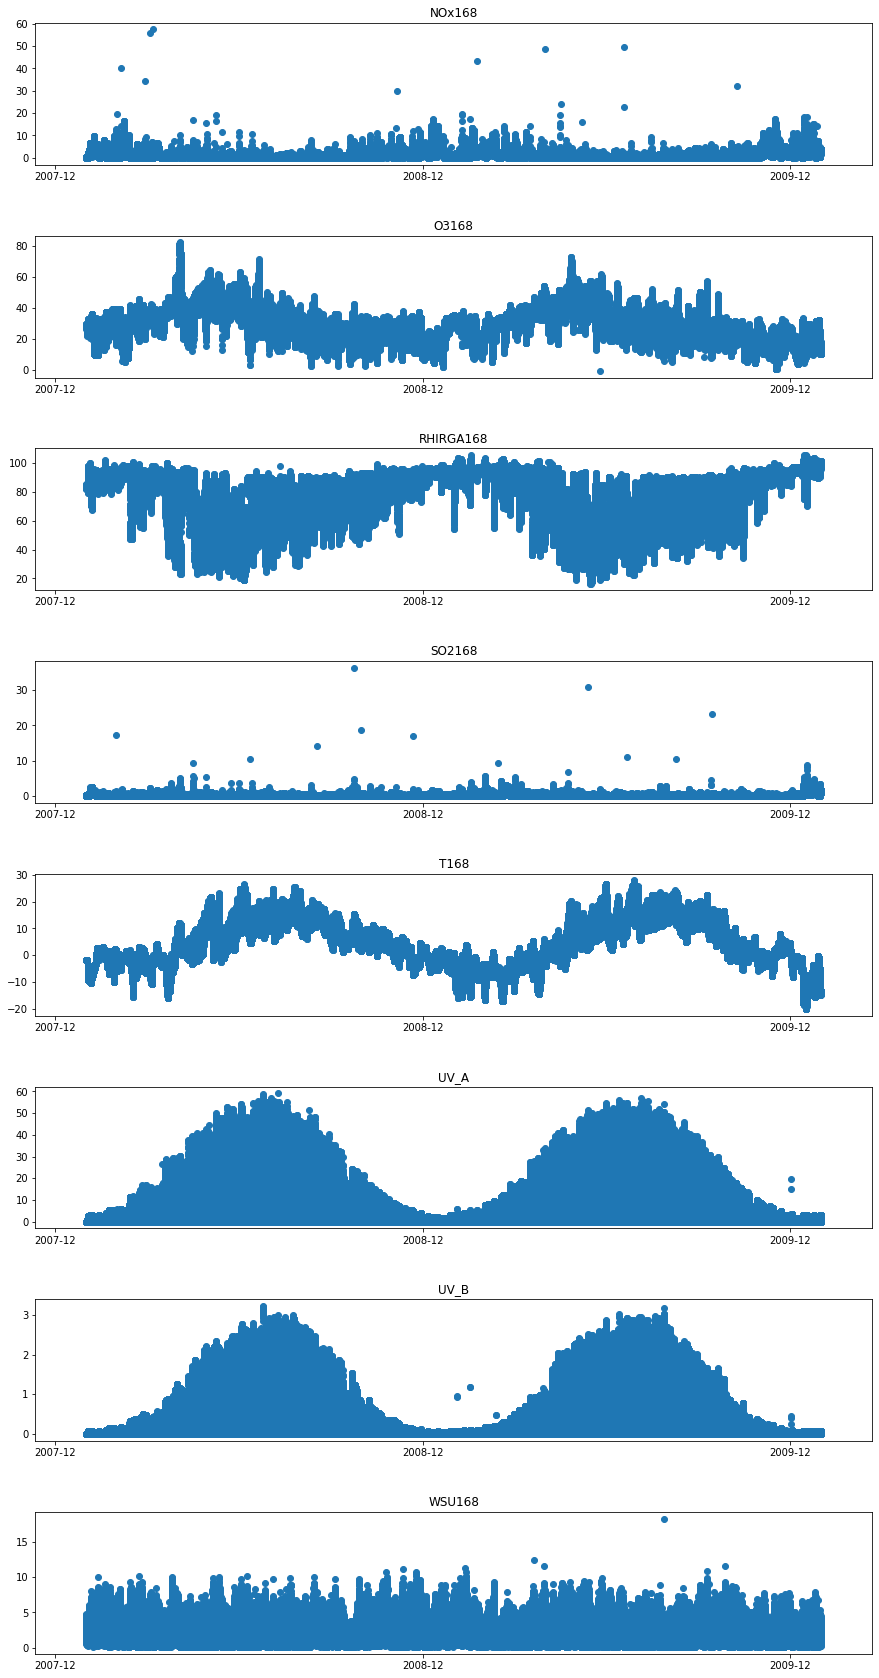

In [81]:
fig, axe = plt.subplots(df.shape[1] - 1,1, figsize = (15, 30))
axe = axe.flatten()
for i in range(1, df.shape[1]):
    axe[i-1].scatter(df.Time, df.iloc[:,i])
    axe[i-1].set_title(df.columns[i])
    axe[i-1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

### Correlation plot
Choose color color bar first

In [13]:
cmap = sns.choose_diverging_palette(as_cmap = True)

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

Change the color bar above then run the code below again to apply new color bar (Don't run the code above again)

(8, 0)

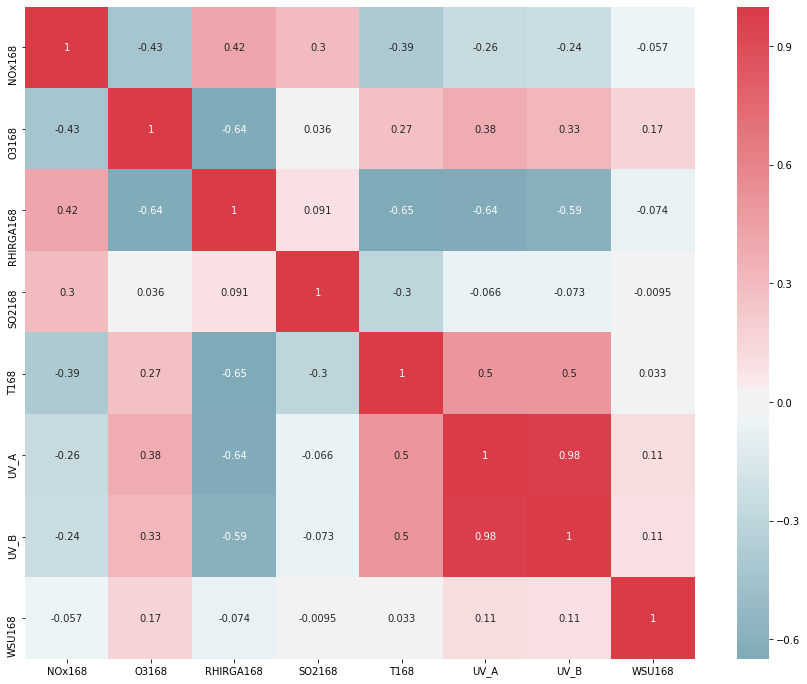

In [14]:
fig, ax = plt.subplots(figsize = (15,12))
sns.heatmap(df.corr(), cmap = cmap, center=0.00, ax = ax, annot = True)
ax.set_ylim(df.shape[1]-1,0)

Correlation matrix

In [15]:
df.corr()

,NOx168,O3168,RHIRGA168,SO2168,T168,UV_A,UV_B,WSU168
NOx168,1.000000,-0.434328,0.415822,0.298519,-0.387454,-0.258587,-0.242463,-0.056616
O3168,-0.434328,1.000000,-0.636815,0.035610,0.266707,0.376464,0.329087,0.168242
RHIRGA168,0.415822,-0.636815,1.000000,0.090873,-0.649550,-0.635176,-0.592820,-0.073989
SO2168,0.298519,0.035610,0.090873,1.000000,-0.296397,-0.066161,-0.072588,-0.009489
T168,-0.387454,0.266707,-0.649550,-0.296397,1.000000,0.501643,0.500669,0.032949
UV_A,-0.258587,0.376464,-0.635176,-0.066161,0.501643,1.000000,0.978138,0.112247
UV_B,-0.242463,0.329087,-0.592820,-0.072588,0.500669,0.978138,1.000000,0.109603
WSU168,-0.056616,0.168242,-0.073989,-0.009489,0.032949,0.112247,0.109603,1.000000


## Event

In [16]:
event['Event'] = event['Type Ia'] + event['Type Ib'] + event['Type II']

In [17]:
event.head()

,Time,Type Ia,Type Ib,Type II,Type Apple,Type Bump,Type Rain,Type Featureless,Nonevent,Undefined,Event
1460,2008-01-01,0,0,0,0,0,0,0,1,0,0
1461,2008-01-02,0,0,0,0,0,0,0,0,1,0
1462,2008-01-03,0,0,0,0,0,0,0,0,0,0
1463,2008-01-04,0,0,0,0,0,0,0,0,1,0
1464,2008-01-05,0,0,0,0,0,0,0,1,0,0


In [18]:
event.describe()

,Type Ia,Type Ib,Type II,Type Apple,Type Bump,Type Rain,Type Featureless,Nonevent,Undefined,Event
count,731.000000,731.000000,731.000000,731.0,731.0,731.0,731.0,731.000000,731.000000,731.00000
mean,0.004104,0.047880,0.151847,0.0,0.0,0.0,0.0,0.313269,0.454172,0.20383
std,0.063974,0.213658,0.359118,0.0,0.0,0.0,0.0,0.464141,0.498236,0.40312
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,0.00000
max,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.00000


In [59]:
event.sum(axis = 0)

Type Ia        3
Type Ib       35
Type II      111
Nonevent     229
Undefined    332
Event        149
dtype: int64

In [19]:
event.isna().sum()

Time                0
Type Ia             0
Type Ib             0
Type II             0
Type Apple          0
Type Bump           0
Type Rain           0
Type Featureless    0
Nonevent            0
Undefined           0
Event               0
dtype: int64

Let's check whether each event is marked only as 1 and 0

In [20]:
for col in event.iloc[:,1:]:
    print(col, event[col].unique())

Type Ia [0 1]
Type Ib [0 1]
Type II [0 1]
Type Apple [0]
Type Bump [0]
Type Rain [0]
Type Featureless [0]
Nonevent [1 0]
Undefined [0 1]
Event [0 1]


Check if each day, there is only one event (exclude newly form Event column)

In [21]:
event.drop('Event', axis = 1).sum(axis = 1).unique()

array([1, 0], dtype=int64)

Let's drop Type Apple, Type Bump, Type Rain and Type Featureless due to no data

In [22]:
event.drop(['Type Apple', 'Type Rain', 'Type Bump', 'Type Featureless'], axis = 1, inplace = True)

## Plot

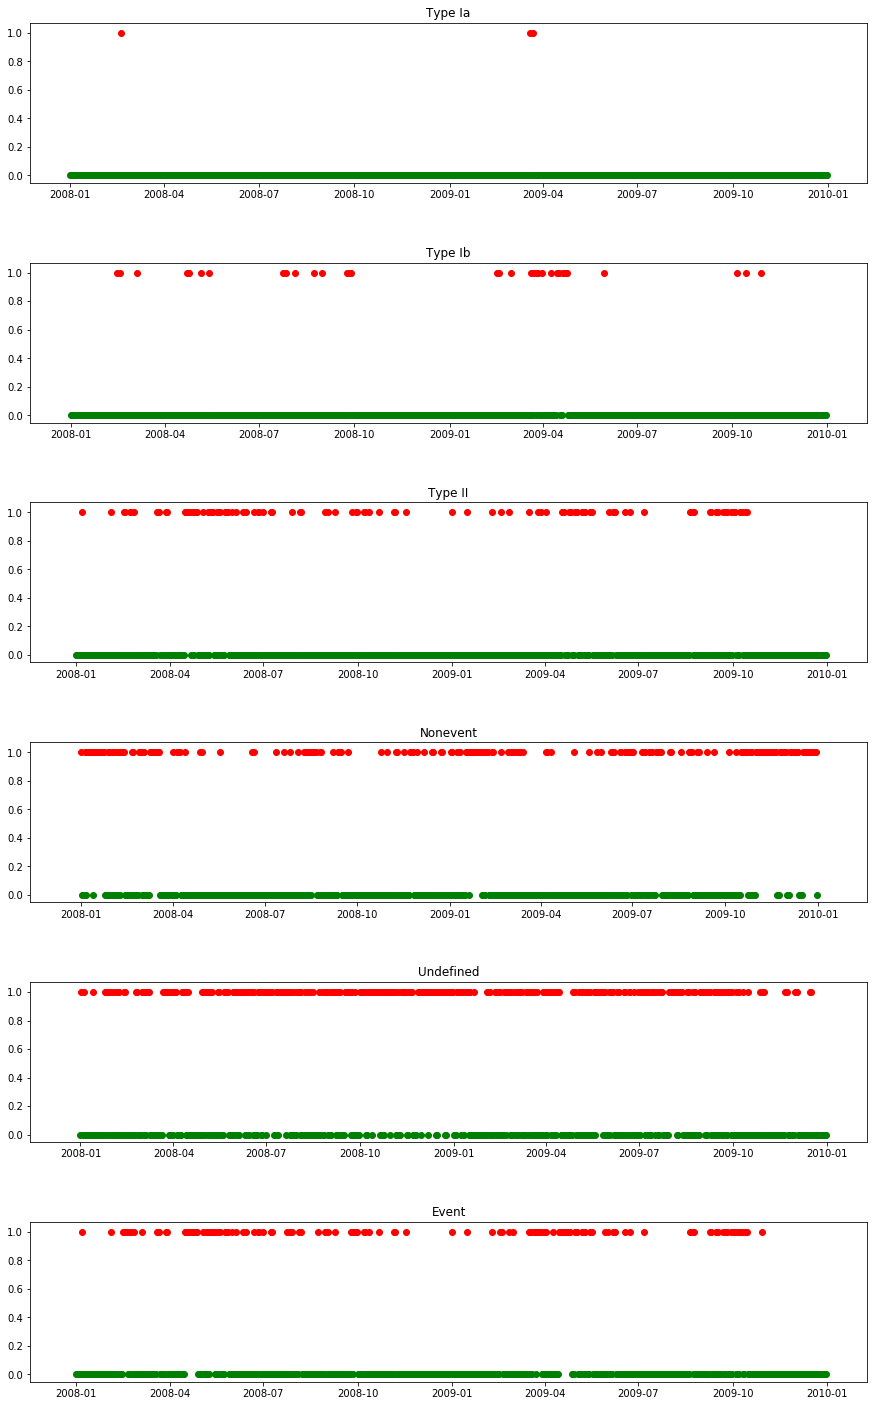

In [23]:
fig, ax = plt.subplots(event.shape[1]-1, figsize = (15, 25))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
for i, value in enumerate(event.columns.values[1:]):
    ax[i].scatter(event[event[value] ==1]["Time"], event[event[value] ==1][value], c = "r")
    ax[i].scatter(event[event[value] ==0]["Time"], event[event[value] ==0][value], c = "green")
    ax[i].set_title(value)

## Condense

In [24]:
condense.head()

,Time,Condensation_sink
206666,2008-01-01 00:09:45,0.001787
206667,2008-01-01 00:19:45,0.001710
206668,2008-01-01 00:29:46,0.001514
206669,2008-01-01 00:39:45,0.001527
206670,2008-01-01 00:49:46,0.001554


In [25]:
condense.describe()

,Condensation_sink
count,102540.000000
mean,0.003777
std,0.003240
min,0.000006
25%,0.001818
50%,0.003016
75%,0.004813
max,0.325251


In [26]:
condense.isna().sum()

Time                    0
Condensation_sink    1158
dtype: int64

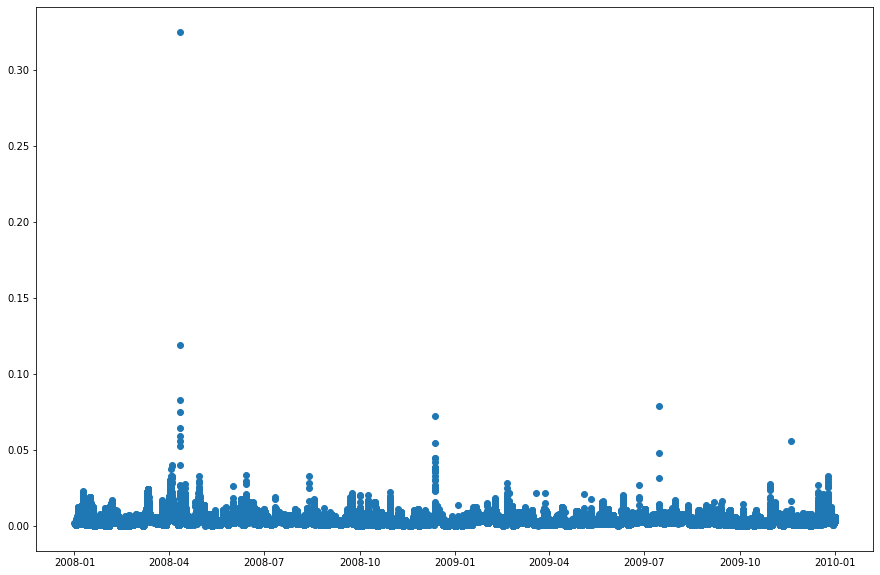

In [37]:
plt.figure(figsize = (15,10))
plt.plot("Time", "Condensation_sink","o", data = condense)
#plt.ylim(0, 0.04)


In [28]:
condense_hourly = condense.groupby([condense["Time"].dt.date,condense["Time"].dt.hour]).mean()

df_hourly = df.groupby([df["Time"].dt.date,df["Time"].dt.hour]).mean()

Text(0.5, 1, 'Hourly correlation')

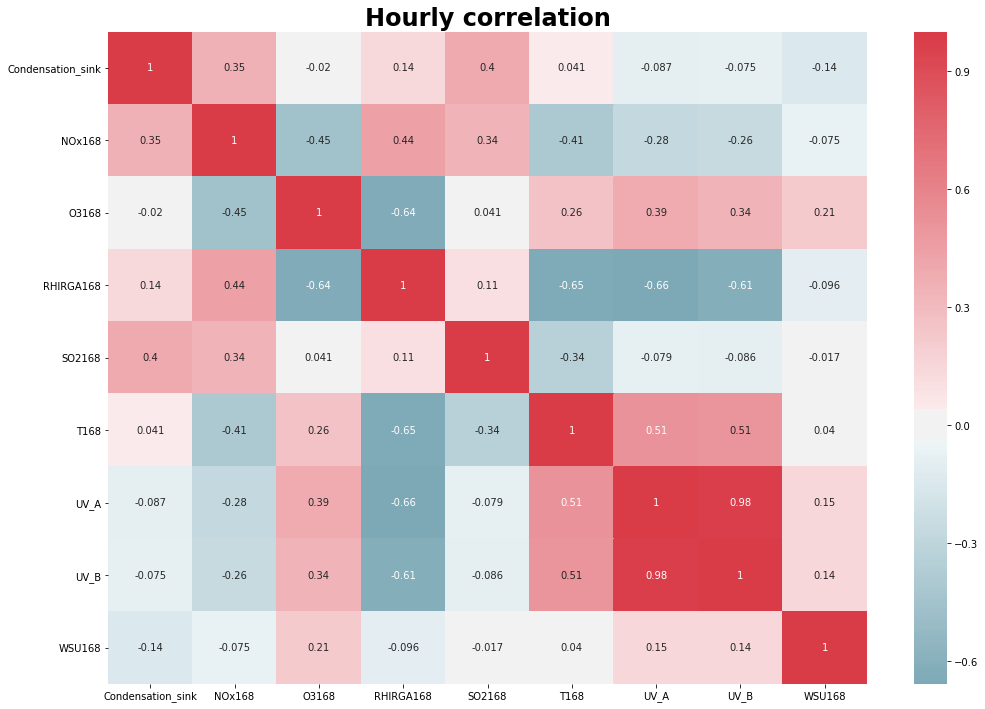

In [29]:
fig, ax = plt.subplots(figsize = (17,12))
sns.heatmap(condense_hourly.join(df_hourly).corr(), cmap = cmap, center=0.00, ax = ax, annot = True)
ax.set_ylim(df.shape[1],0)
ax.set_title('Hourly correlation', weight = "bold", fontsize=24)

# Remove outlier???

# Interaction of all variable based on event / events

3 data:
Parameters
Event
Condensation sink
What we gonna do:
## Each single parameter changes with sink and event
## Correlation

In [30]:
condense_daily = condense.groupby([condense["Time"].dt.date]).mean()
df_daily = df.groupby([df["Time"].dt.date]).mean()

In [31]:
temp = event[["Event", "Nonevent", "Time"]].set_index('Time').join(condense_daily).join(df_daily)

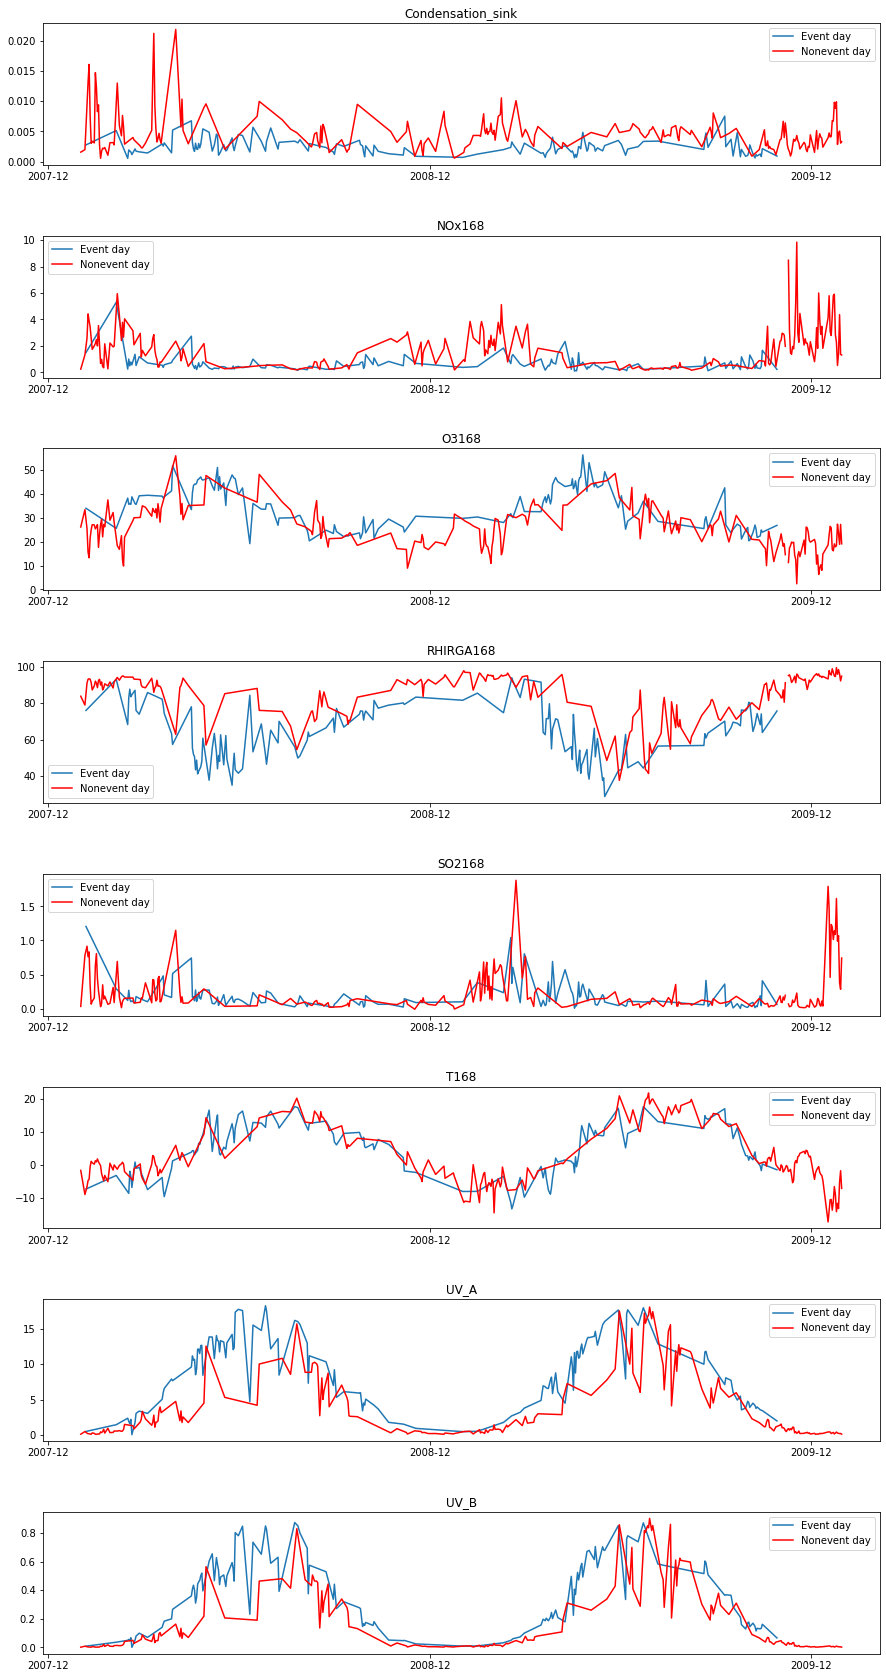

In [32]:
fig, axe = plt.subplots(8, figsize = (15, 30))
for i in range(8):
    axe[i].plot(temp[temp.Event == 1].iloc[:,i+2], label = 'Event day')
    axe[i].plot(temp[temp.Nonevent == 1].iloc[:,i+2], c = 'red', label = 'Nonevent day')
    axe[i].set_title(temp.columns[i+2])
    axe[i].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    axe[i].legend()
#for i in range(8):
#    axe[i,1].plot(temp[temp.Nonevent == 1].iloc[:,i+2], c = 'red')
#    axe[i,1].set_title('Nonevent day ' + temp.columns[i+2])
#    axe[i,1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

Text(0.5, 1, 'Daily correlation on Event day')

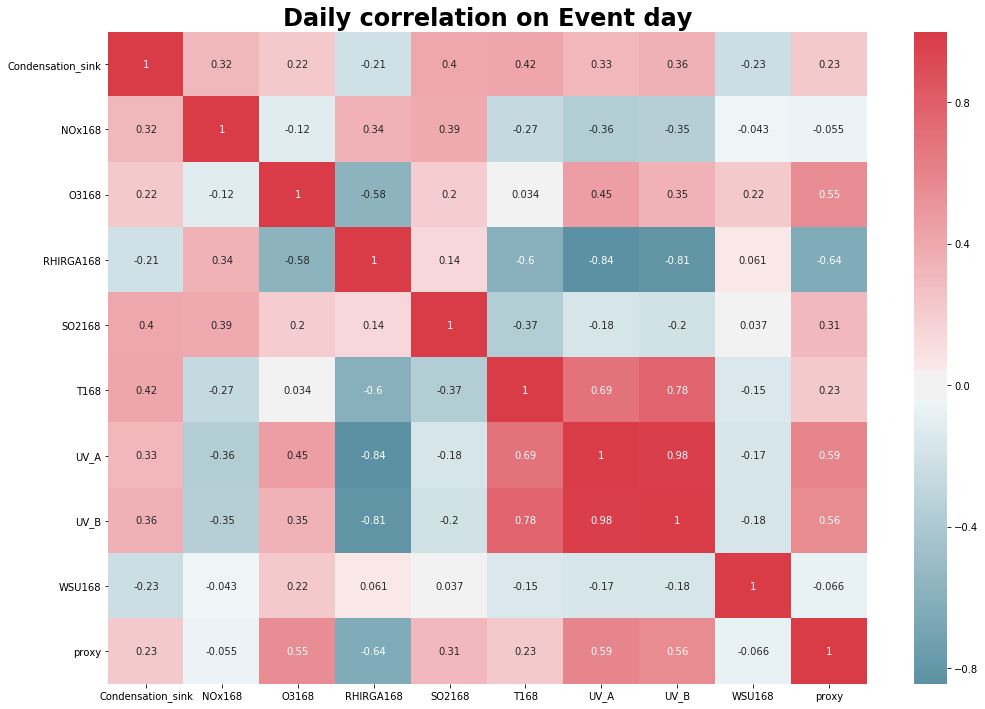

In [45]:
fig, ax = plt.subplots(figsize = (17,12))
sns.heatmap(temp[temp.Event == 1].iloc[:,2:].corr(), cmap = cmap, center=0.00, ax = ax, annot = True)
ax.set_ylim(df.shape[1] +1,0)
ax.set_title('Daily correlation on Event day', weight = "bold", fontsize=24)

Text(0.5, 1, 'Daily correlation on Non-Event day')

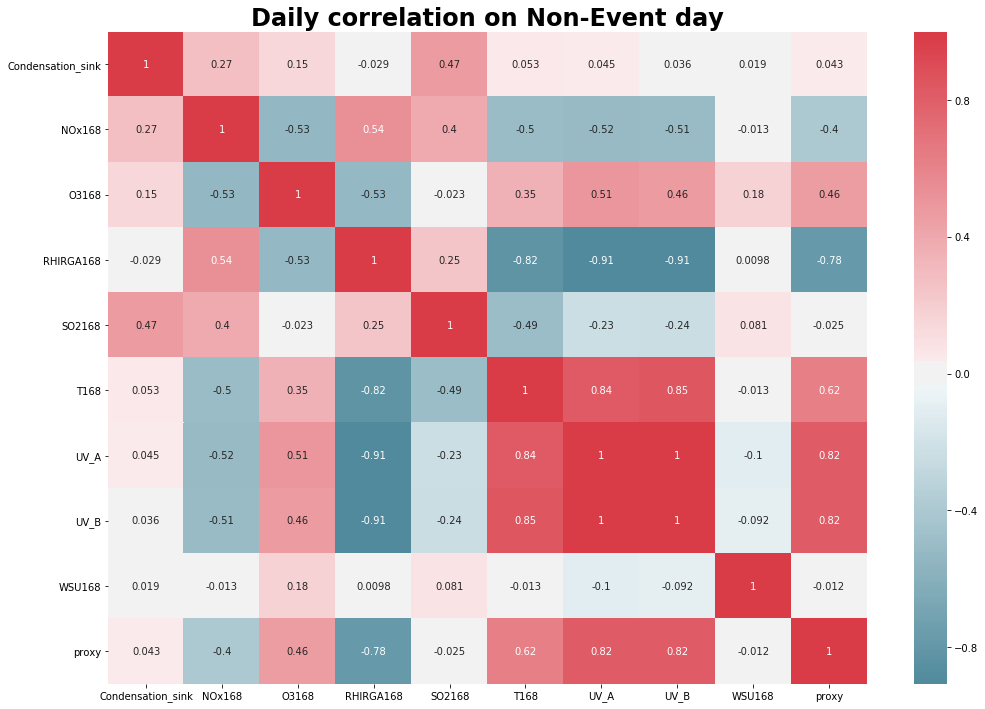

In [46]:
fig, ax = plt.subplots(figsize = (17,12))
sns.heatmap(temp[temp.Nonevent == 1].iloc[:,2:].corr(), cmap = cmap, center=0.00, ax = ax, annot = True)
ax.set_ylim(df.shape[1] +1,0)
ax.set_title('Daily correlation on Non-Event day', weight = "bold", fontsize=24)

$[H_2SO_4]_{proxy} = k.\frac{[SO_2][UVB]}{CS}$

In [54]:
temp['proxy'] = temp['SO2168'] * temp['UV_B'] * 9.9e-7 / temp['Condensation_sink'] * 2.62e-6 / 64 * 6.023e23 / 1e6

In [55]:
temp['proxy']

Time
2008-01-01     1023.165603
2008-01-02    11768.382664
2008-01-03     7931.196339
2008-01-04    27877.732612
2008-01-05    87221.607362
                  ...     
2009-12-27    30601.018653
2009-12-28     7927.310604
2009-12-29    10515.362473
2009-12-30    13761.604107
2009-12-31    67019.278424
Name: proxy, Length: 731, dtype: float64

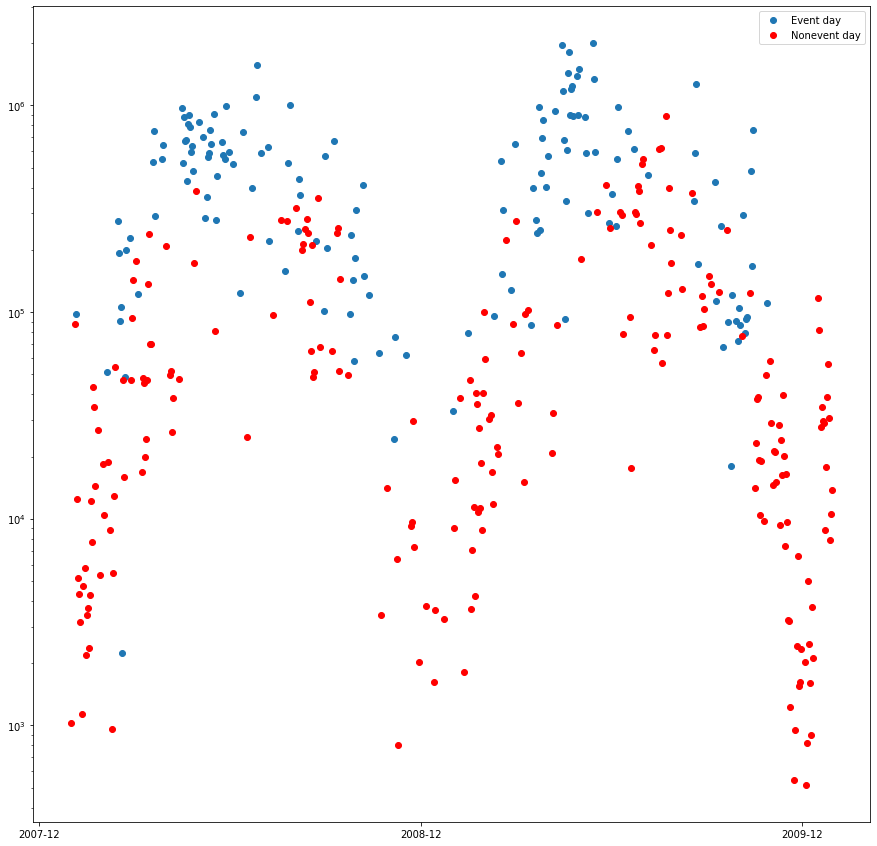

In [57]:
fig, axe = plt.subplots(figsize = (15, 15))
axe.plot(temp[temp.Event == 1]['proxy'], 'o', label = 'Event day')
axe.plot(temp[temp.Nonevent == 1]['proxy'], 'o', c = 'red', label = 'Nonevent day')
  #axe.set_title(temp.columns[i+2])
axe.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=12, bymonthday=1, interval=1, tz=None))
axe.set_yscale('log')
axe.legend()

In [77]:
temp2 = temp[temp.Event == 1].reset_index(level = 0).groupby(temp[temp.Event == 1].reset_index(level = 0)['Time'].dt.month).mean()
temp3 = temp[temp.Nonevent == 1].reset_index(level = 0).groupby(temp[temp.Nonevent == 1].reset_index(level = 0)['Time'].dt.month).mean()

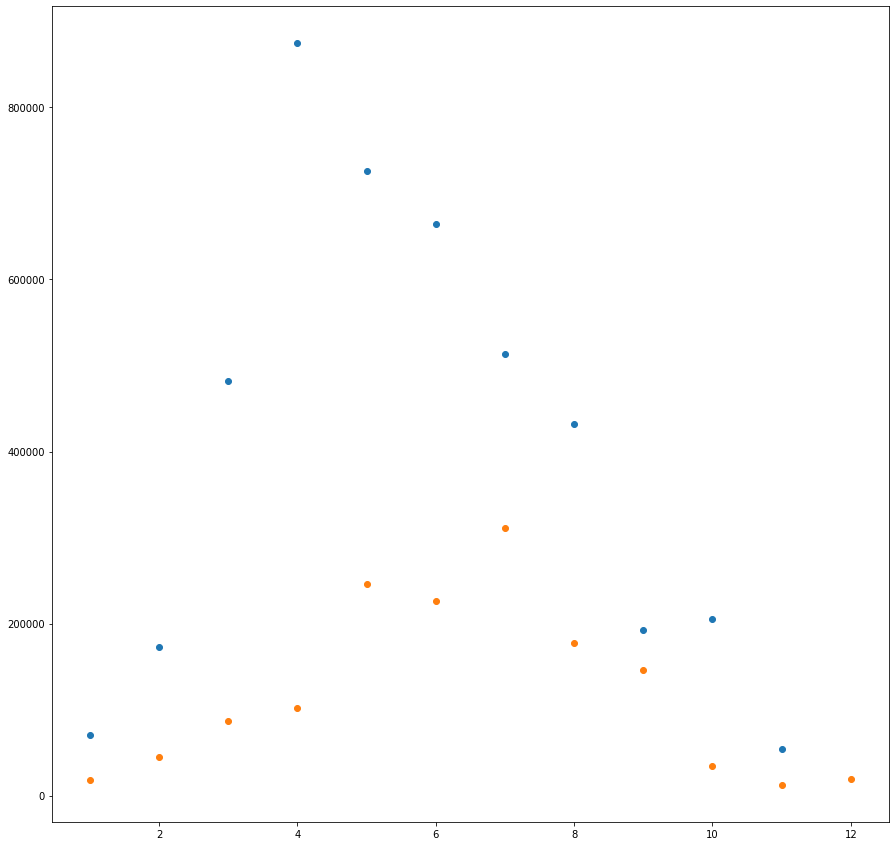

In [80]:
plt.figure(figsize = (15, 15))
plt.plot(temp2.proxy, 'o', temp3.proxy, 'o')

In [71]:
temp2

,Event,Nonevent,Condensation_sink,NOx168,O3168,RHIRGA168,SO2168,T168,UV_A,UV_B,WSU168,proxy
Time,,,,,,,,,,,,
1,1,0,0.001563,0.766569,31.414597,81.098659,0.562361,-7.811637,0.504156,0.009735,2.829676,70002.575738
2,1,0,0.002088,1.222080,34.336455,83.829837,0.270062,-5.551959,2.210955,0.054488,2.526140,172733.495817
3,1,0,0.002294,0.609597,39.318485,72.795774,0.282263,-4.769916,6.462095,0.187323,2.170706,481910.467833
4,1,0,0.002550,0.710536,44.749675,52.393080,0.221842,4.273733,10.495356,0.429685,2.165437,874437.565061
5,1,0,0.002632,0.361605,44.686441,47.788621,0.123050,9.577531,13.969273,0.607689,2.189631,726208.695022
6,1,0,0.002773,0.401919,32.513156,53.672734,0.105294,11.360131,14.950823,0.690164,1.923942,664969.180498
7,1,0,0.003469,0.321891,30.466153,58.095528,0.112209,14.734891,13.579642,0.674570,1.717591,513343.841416
8,1,0,0.002475,0.422963,25.457848,63.240333,0.096811,11.705865,10.238470,0.517710,1.929174,431605.930682
9,1,0,0.002648,0.633254,25.947599,71.691301,0.092420,8.601424,5.463566,0.244510,2.055313,192976.264519
